In [1]:
import pathlib

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import display, Audio
from sklearn.preprocessing import normalize
from scipy import signal

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

sampling_rate=44100


/Users/discort/ml-course/.env/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


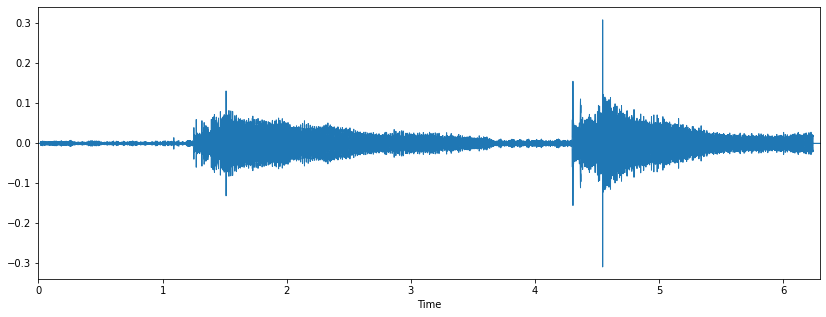

In [2]:
#audio_path = 'data/beatles/mp3s-32k/Let_It_Be/06-Let_It_Be.mp3'
audio_path = 'data/basicchords.mp3'
audio_waveform, sampling_rate = librosa.core.load(audio_path, sr=None)
audio_waveform = audio_waveform[:sampling_rate * 12]
print(f'sampling_rate={sampling_rate}')

librosa.display.waveplot(audio_waveform, sr=sampling_rate)
Audio(data=audio_waveform, rate=sampling_rate)

In [3]:
def log_compression(v, gamma=1):
    """Logarithmically compresses a value or array

    Args:
        v: Value or array
        gamma: Compression factor

    Returns:
        v_compressed: Compressed value or array
    """
    return np.log(1 + gamma * v)

def smooth_downsample_feature_sequence(X, filt_len=41, w_type='boxcar'):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by convolution with a filter kernel

    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
    """
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    return X_smooth

In [4]:
hop_length = 2048
window_size = 4096
chromagram = librosa.feature.chroma_stft(audio_waveform, sr=sampling_rate, norm=None,
                                         n_fft=window_size, hop_length=hop_length, tuning=0)
print(f'chroma shape={chromagram.shape}')

chroma shape=(12, 136)


In [5]:
# plt.figure(figsize=(18, 16))
# gamma_set = [0, 1, 10, 100]
# M = len(gamma_set)
# #C = chromagram / chromagram.max()
# C = chromagram

# for m in range(M):
#     ax = plt.subplot(M, 1, m + 1)
#     gamma = gamma_set[m]
#     if gamma == 0:
#         C_compressed = C
#         title = 'No compression'
#     else:
#         C_compressed = log_compression(C, gamma=gamma)
#         title = '$\gamma$=%d' % gamma
#     librosa.display.specshow(C_compressed, x_axis='time', 
#                              y_axis='chroma', cmap='gray_r', sr=sampling_rate, hop_length=hop_length)
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Chroma')
#     plt.clim([0, np.max(C_compressed)])
#     plt.title(title)
#     plt.colorbar()

# plt.tight_layout()

In [6]:
# plt.figure(figsize=(18, 16))
# filter_set = [10, 20, 30, 40]
# M = len(filter_set)
# for m in range(M):
#     ax = plt.subplot(M, 1, m + 1)
#     filt_len = filter_set[m]
#     filtered = smooth_downsample_feature_sequence(chromagram, filt_len=filt_len)
#     title = f'filt_len={filt_len}'
#     librosa.display.specshow(filtered, x_axis='time', 
#                              y_axis='chroma', cmap='gray_r', sr=sampling_rate, hop_length=hop_length)
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Chroma')
#     plt.title(title)
#     plt.colorbar()

# plt.tight_layout()

In [7]:
# Apply logarighmic compression
# chromagram = chromagram / chromagram.max()
# chromagram = log_compression(chromagram, gamma=10)

In [8]:
# Apply temporal smooting
# chromagram = smooth_downsample_feature_sequence(chromagram, filt_len=5)

chord_sim shape=(24, 136)
chord_max shape=(24, 136)


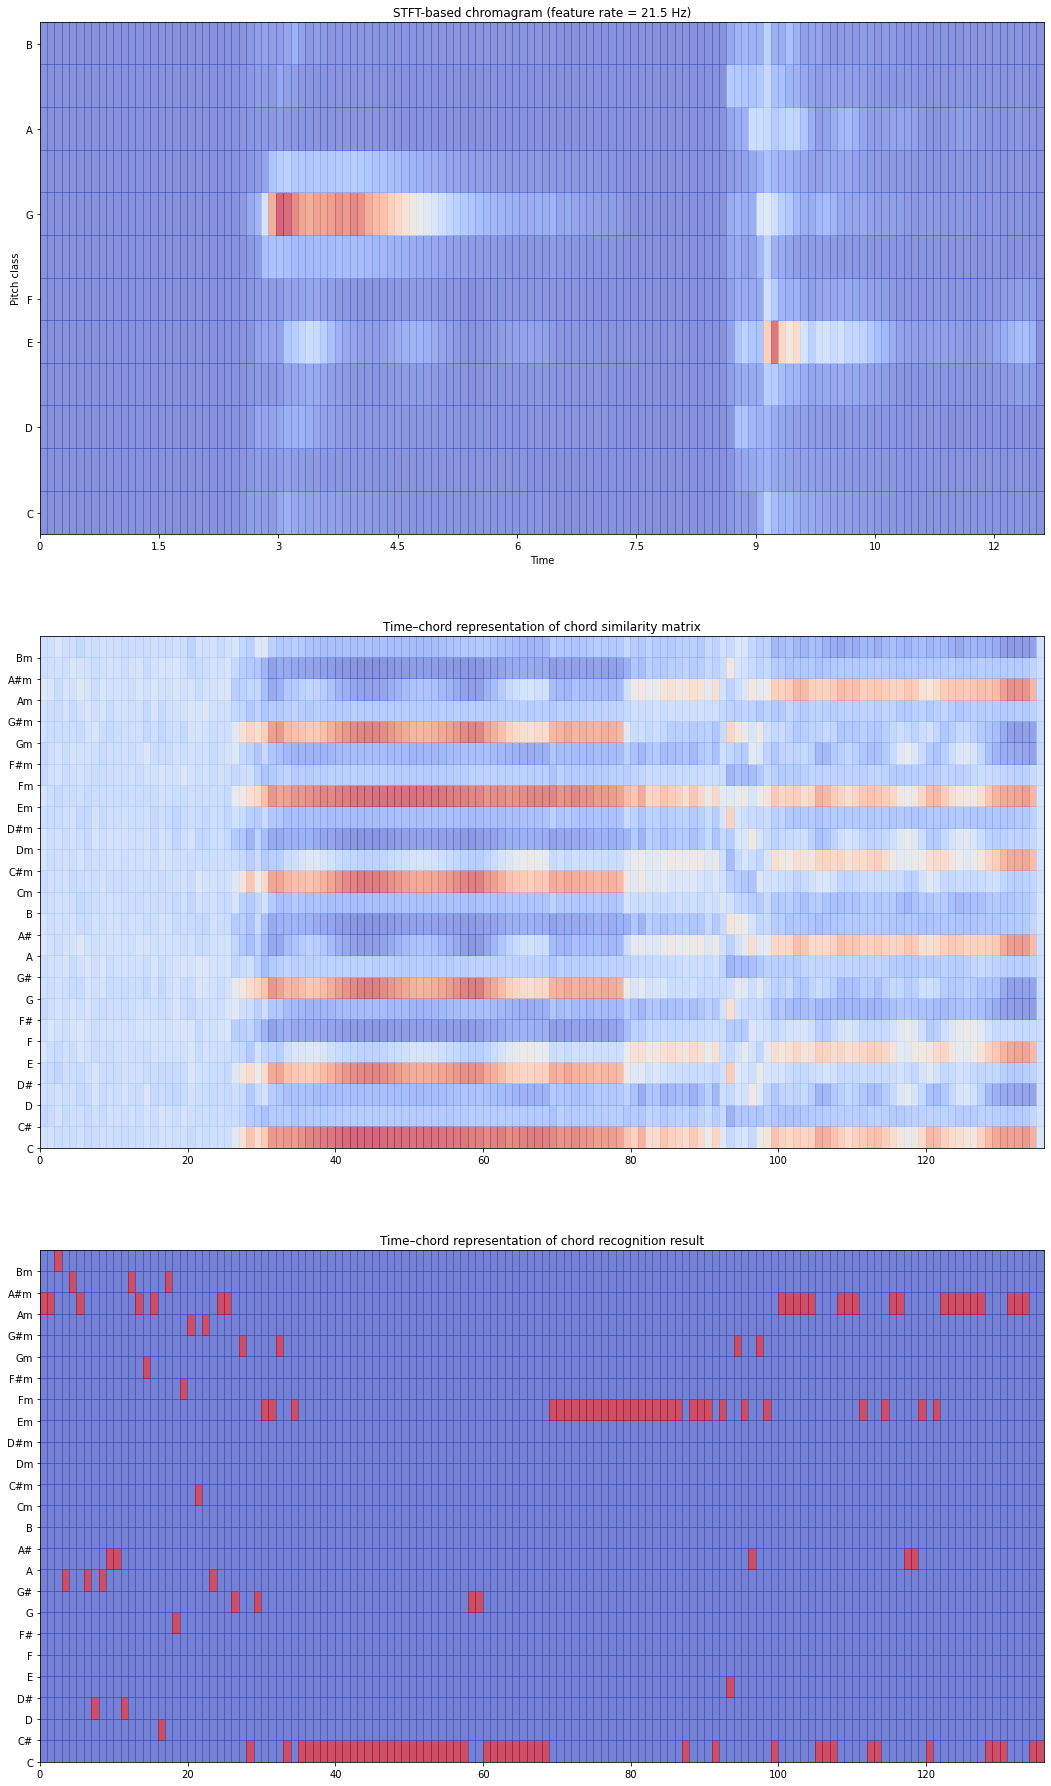

In [9]:
from utils import get_chord_labels, chord_recognition_template

# Chord recognition
chord_sim, chord_max = chord_recognition_template(chromagram, nonchord=False, seventh=False)
print(f'chord_sim shape={chord_sim.shape}')
print(f'chord_max shape={chord_max.shape}')
chord_labels = get_chord_labels(nonchord=False, seventh=False)

Fs_X = sampling_rate / hop_length
M = chromagram.shape[1]
Tcoef = np.arange(M) * hop_length / sampling_rate
Xdur = int(audio_waveform.shape[0] / sampling_rate)

fig, ax = plt.subplots(3, 1, figsize=(18, 32))
ax[0].set_title('STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
spec_axes = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm',
                                     ax=ax[0], alpha=0.6)

# Visualise similarity in time–chord representation
ax[1].set_yticks(np.arange(len(chord_labels)))
ax[1].set_yticklabels(chord_labels)
ax[1].set_title('Time–chord representation of chord similarity matrix')
ax[1].pcolormesh(chord_sim, cmap='coolwarm', alpha=0.6)
# ax[1].set_xticks(np.arange(0, M, Xdur))
# ax[1].set_xticklabels(Tcoef)

# Binary time–chord representation
ax[2].set_yticks(np.arange(len(chord_labels)))
ax[2].set_yticklabels(chord_labels)
ax[2].set_title('Time–chord representation of chord recognition result')
ax[2].pcolormesh(chord_max, cmap='coolwarm', alpha=0.7)

In [10]:
# To obtain beatles dataset for evaluation
# http://labrosa.ee.columbia.edu/projects/chords/beatles.zip
# more data http://www.isophonics.net/content/reference-annotations-beatles
import os
from utils import convert_chord_ann_matrix, read_structure_annotation, read_csv
# Annotations
fn_ann = os.path.join('data', 'beatles', 'chordlabs', 'Let_It_Be/06-Let_It_Be.lab')
# fn_ann = os.path.join('data', 'let_it_be_simplified.csv')
chord_labels = get_chord_labels(ext_minor='m', nonchord=False, seventh=False)
N_X = chromagram.shape[1]

ann_matrix, _, _, _ = convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)

In [11]:
from metrics import compute_eval_measures
P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)
title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
print(title)

Evaluation result (N=136, TP=13, FP=123, FN=85, P=0.096, R=0.133, F=0.111)


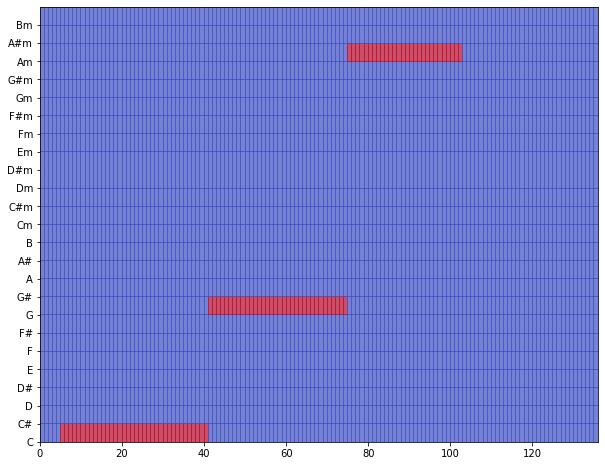

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Binary time–chord representation
ax.set_yticks(np.arange(len(chord_labels)))
ax.set_yticklabels(chord_labels)
ax.pcolormesh(ann_matrix, cmap='coolwarm', alpha=0.7)

In [13]:
A_est_df = pd.read_csv('FMP_C5_transitionMatrix_Beatles.csv', delimiter=';')
A_est = A_est_df.to_numpy('float64')

HMM-based approach. Evaluation result (N=136, TP=36, FP=100, FN=62, P=0.265, R=0.367, F=0.308)


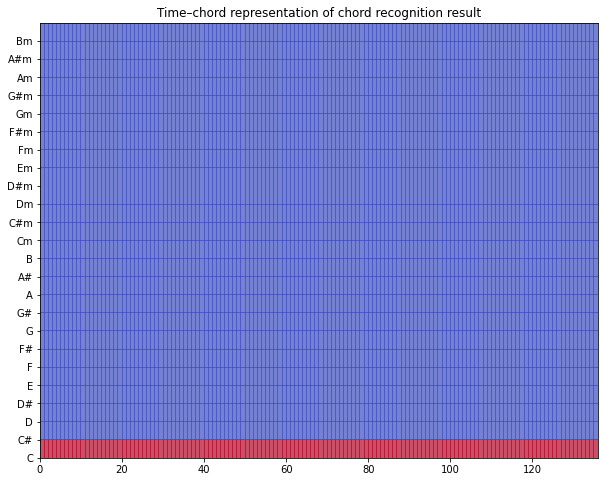

In [14]:
from utils import uniform_transition_matrix, viterbi_log_likelihood

I = 24
A = uniform_transition_matrix(p=0.5)
C = 1 / I * np.ones((1, I))
B_O = chord_sim

chord_HMM, _, _, _ = viterbi_log_likelihood(A_est, C, B_O)
P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_HMM)
title = 'HMM-based approach. Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
print(title)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_yticks(np.arange(len(chord_labels)))
ax.set_yticklabels(chord_labels)
ax.set_title('Time–chord representation of chord recognition result')
ax.pcolormesh(chord_HMM, cmap='coolwarm', alpha=0.7)